# The Method

In [1]:
!pip install activeSVC==4.0.1
!pip install psutil

In [2]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition
import pandas as pd
import pickle
import os, psutil
import resource


def text_create(path, name, msg):
    full_path = path + "/" + name + '.pickle'
    f=open(full_path,'wb') 
    pickle.dump(msg,f)
    f.close()

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        return elapsed_time
        




# Download and Load Tabula Muris Data

In [3]:
import urllib.request
import shutil

with urllib.request.urlopen("https://caltech.box.com/shared/static/p2bjcw4ym5ow22yc5h2ld4d7m5wzrw8t.pickle") as response, open('./tabula.pickle', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [4]:
import pickle
with open('tabula.pickle','rb') as handle:
    raw_data = pickle.load(handle)
    gene=np.array(pickle.load(handle))
    target=np.array(pickle.load(handle))


data=normalize(np.transpose(raw_data),axis=1, norm='l2')

del raw_data

idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))

(55656, 8661) (55656,) 58
(44524, 8661)
(11132, 8661)


# min_complexity

## Define Parameters and Work Space

In [5]:
'''
Parameters
'''
num_features = 50
num_samples=20
init_samples=50
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory results 
Successfully created the directory results/min_complexity 
Successfully created the directory results/min_complexity/test_50_20 


## Select Genes and Save Results

Elapsed time: 16.6539 seconds
feature 0 : gene [0]  50 samples
training error=317.2285508938999 test error=324.6383399209486
training accuracy=0.17377144910610007 test accuracy=0.17238591448077614
Elapsed time: 23.9992 seconds
feature 1 : gene 6959  70 samples
training error=233.78674422783217 test error=239.13726194753863
training accuracy=0.25312191177791754 test accuracy=0.24703557312252963
Elapsed time: 12.2314 seconds
feature 2 : gene 1154  90 samples
training error=257.039933519001 test error=263.5868666906216
training accuracy=0.39183361782409487 test accuracy=0.3850161696011498
Elapsed time: 12.1339 seconds
feature 3 : gene 5611  110 samples
training error=274.6662249573264 test error=281.2417355371901
training accuracy=0.4310259635252897 test accuracy=0.42265540783327343
Elapsed time: 11.5193 seconds
feature 4 : gene 6739  130 samples
training error=272.5186640912766 test error=279.3354293927417
training accuracy=0.44391788698230167 test accuracy=0.4333453108156666
Elapsed tim

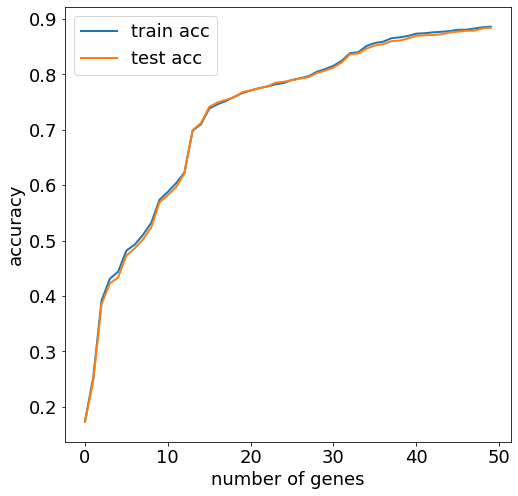

In [6]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores, step_times= min_complexity(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples, balance=balance)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

# min_aquisition

## Define Parameters and Work Space

In [5]:
'''
Parameters
'''
num_features = 20
num_samples=30
init_samples=50

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_acquisition failed
Creation of the directory results/min_acquisition/test_20_30 failed


## Select Genes and Save Results

Elapsed time: 15.0219 seconds
feature 0 : gene [6739]  50 samples
training error=365.98075195400236 test error=368.56611570247935
training accuracy=0.28436348935405625 test accuracy=0.27389507725476103
Elapsed time: 18.7046 seconds
feature 1 : gene 7369  50 samples
training error=277.9271404186506 test error=279.4082824290334
training accuracy=0.3688572455305004 test accuracy=0.35896514552641035
Elapsed time: 17.9517 seconds
feature 2 : gene 5611  50 samples
training error=275.1804869283982 test error=277.70634207689545
training accuracy=0.3886892462492139 test accuracy=0.3784584980237154
Elapsed time: 18.9131 seconds
feature 3 : gene 2766  50 samples
training error=268.536856526817 test error=267.37279913762126
training accuracy=0.4120025154972599 test accuracy=0.4006467840459935
Elapsed time: 20.5769 seconds
feature 4 : gene 6741  50 samples
training error=268.7147605785644 test error=265.73796263025514
training accuracy=0.4133276435181026 test accuracy=0.4032518864534675
Elapsed tim

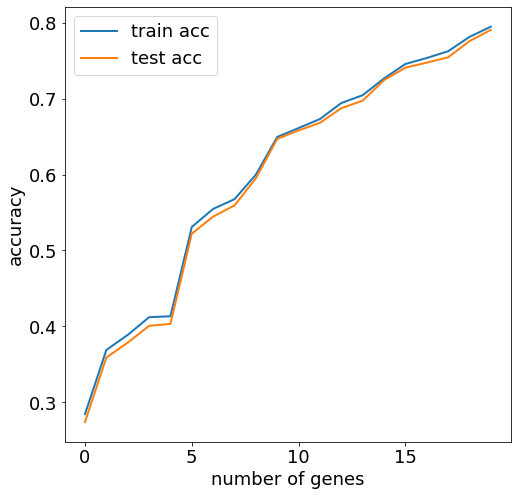

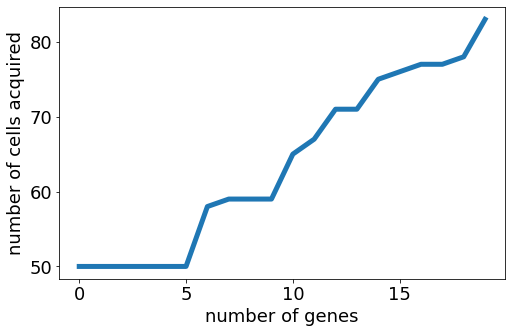

In [6]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores,step_times= min_acquisition(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples, init_samples=init_samples)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# T-SNE of Results

In [7]:
with open('tabula.pickle','rb') as handle:
    raw_data = pickle.load(handle)
    gene=np.array(pickle.load(handle))
    target=np.array(pickle.load(handle))

data_tmp=normalize(raw_data,axis=1, norm='l2')
alpha = 100
data = np.log1p(data_tmp*alpha).toarray().transpose()

del raw_data,data_tmp

print(np.shape(data),np.shape(target),len(np.unique(target)))

(55656, 8661) (55656,) 58


## T-SNE of Original Dataset

In [ ]:
classes=[39,14,46,0,21,51,7,44,9,28,29,45,13,27,50,22,41,52]
keys=['B cell','T cell','mesenchymal cell','keratinocyte','basal cell of epidermis', 'macrophage','kidney PST epithelial cell', 'hepatocyte','granulocyte','natural killer cell','immature T cell','alveolar macrophage', 'bladder cell','antigen presenting cell','stromal cell','endothelial cell','mesenchymal stem cell','bladder urothelial cell']

idx=list([])
labels=target
for i in range(len(classes)):
    tmp=list(np.where(target==classes[i])[0])
    labels[tmp]=i+1
    idx =idx+ tmp
others=list(set(range(np.shape(data)[0])).difference(set(idx)))
labels[others]=-1

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)
Y=TSNE(n_components=2).fit_transform(pcaproj)

plt.figure(figsize=(12,8))
c_cmap = plt.get_cmap('tab20', len(classes))
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s= 0.5) # plot all cells as background
plt.scatter(Y[idx,0], Y[idx,1], c=labels[idx], s=0.5,cmap=c_cmap) # plot subpopulation cells on top
cbar=plt.colorbar(ticks=np.arange(1,len(classes)+1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys,fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")
import pickle
f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

In [ ]:
data_selected=data[:,feature_selected]

pca=PCA(n_components=10,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2,perplexity=200,early_exaggeration=1).fit_transform(pcaproj)

plt.figure(figsize=(12,8))

c_cmap = plt.get_cmap('tab20', len(classes))
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s= 0.01) # plot all cells as background
plt.scatter(Y_selected[idx,0], Y_selected[idx,1], c=labels[idx], s=0.5,cmap=c_cmap) # plot subpopulation cells on top
cbar=plt.colorbar(ticks=np.arange(1,len(classes)+1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys,fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wpca.pdf',bbox_inches="tight")
import pickle
f=open(path+'/tsne_selected_wPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

In [ ]:

size=len(feature_selected)
plt.figure(figsize=(30,0.25*size))
gs = gridspec.GridSpec(int(size/10), 10, width_ratios=[7,7,7,7,7,7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data[:,f],s=0.005)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")    